In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import os
import numpy as np


2025-01-19 20:21:31.838997: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-19 20:21:31.898302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737318091.923587   14957 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737318091.933455   14957 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 20:21:31.976707: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
dataset_dir = "/mnt/c/MyEverything/PythonProjects/Recent_projects/cnn_analysis/MiniProjectCNN/Fabric Defect Dataset/Processed_dataset/Augmented_Processed_dataset"
train_dir = dataset_dir


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.1,  # Reduced from 0.2
    zoom_range=0.1,   # Reduced from 0.2
    rotation_range=10, # Reduced from 20
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,  # Added
    height_shift_range=0.1,  # Added
    brightness_range=[0.9, 1.1],  # Added
    validation_split=0.2,
    fill_mode='nearest'
)


train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',  
    subset='training',
    color_mode='grayscale'
)
val_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',  
    subset='validation',
    color_mode='grayscale'
)



Found 5045 images belonging to 6 classes.
Found 1257 images belonging to 6 classes.


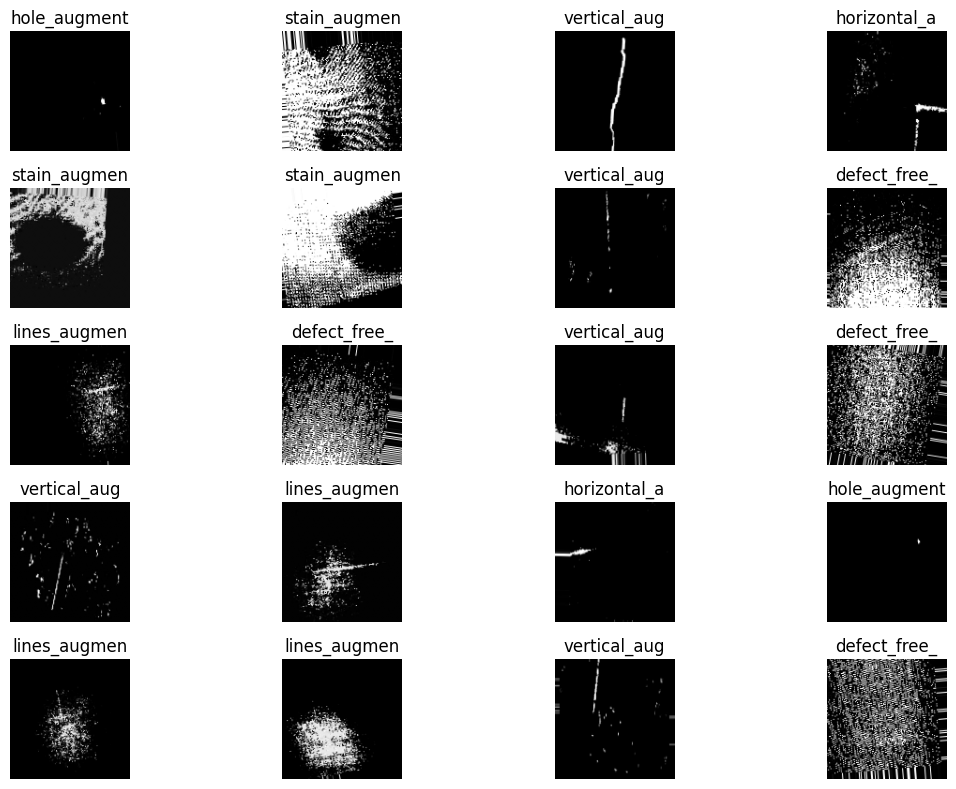

In [4]:
import matplotlib.pyplot as plt

images, labels = next(train_set) 
class_labels = {v: k for k, v in train_set.class_indices.items()}

plt.figure(figsize=(12, 8))
for i in range(20):  # note 20 here
    plt.subplot(5, 4, i + 1)        #5 x 4 = 20 lol
    plt.imshow(images[i].squeeze(), cmap='gray')  #squeeze() for grayscale images
    plt.title(f"{class_labels[np.argmax(labels[i])][0:12]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [5]:
cnn = tf.keras.models.Sequential([
    # First Convolutional Block
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=[128, 128, 1]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.25),
    
    # Second Convolutional Block
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.25),
    
    # Third Convolutional Block
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.25),
    
    # Dense Layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

/mnt/c/Windows/system32/tf_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1737318187.708537   14957 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
cnn.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Enhanced callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=11,
    restore_best_weights=True
    #min_delta=0.001
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)

In [7]:
class_counts = {class_name: 0 for class_name in train_set.class_indices.keys()}

# `classes` contains the numeric class labels for all images in the dataset
for label in train_set.classes:
    class_name = list(train_set.class_indices.keys())[label]
    class_counts[class_name] += 1

# Print the count of images per class
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

# Total images
print(f"Total images in the training set: {sum(class_counts.values())}")

Class 'defect_free_processed': 892 images
Class 'hole_augmented_processed': 900 images
Class 'horizontal_augmented_processed': 820 images
Class 'lines_augmented_processed': 749 images
Class 'stain_augmented_processed': 956 images
Class 'vertical_augmented_processed': 728 images
Total images in the training set: 5045


In [8]:
# Calculate sample weights instead of class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_set.classes),
    y=train_set.classes
)

# Create a sample weights array
sample_weights = np.zeros(len(train_set.classes))
for idx, label in enumerate(train_set.classes):
    sample_weights[idx] = class_weights[label]


In [9]:

# Modify the generator to include sample weights
class WeightedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator, sample_weights):
        self.generator = generator
        self.sample_weights = sample_weights
    
    def __len__(self):
        return len(self.generator)
    
    def __getitem__(self, index):
        X, y = self.generator[index]
        # Calculate the indices for this batch
        start_idx = index * self.generator.batch_size
        end_idx = min((index + 1) * self.generator.batch_size, len(self.sample_weights))
        batch_weights = self.sample_weights[start_idx:end_idx]
        return X, y, batch_weights


In [10]:

# Create weighted generators
weighted_train_set = WeightedDataGenerator(train_set, sample_weights)


In [12]:

# Training
with tf.device('/GPU:0'):
    history = cnn.fit(
        weighted_train_set,
        validation_data=val_set,
        epochs=100,  # Increased epochs since we have better early stopping
        callbacks=[early_stopping, reduce_lr]
    )

/mnt/c/Windows/system32/tf_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1737318295.603020   15306 service.cc:148] XLA service 0x7f3270002550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737318295.603128   15306 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-01-19 20:24:55.718318: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737318296.118558   15306 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/158 ━━━━━━━━━━━━━━━━━━━━ 35:16 13s/step - accuracy: 0.0625 - loss: 2.8838 - precision: 0.1053 - recall: 0.0625

I0000 00:00:1737318305.759196   15306 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


158/158 ━━━━━━━━━━━━━━━━━━━━ 72s 373ms/step - accuracy: 0.3624 - loss: 1.9453 - precision: 0.4132 - recall: 0.3013 - val_accuracy: 0.1782 - val_loss: 4.9020 - val_precision: 0.1782 - val_recall: 0.1782 - learning_rate: 1.0000e-04
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 49s 312ms/step - accuracy: 0.5119 - loss: 1.3719 - precision: 0.5752 - recall: 0.4394 - val_accuracy: 0.3278 - val_loss: 4.5308 - val_precision: 0.3285 - val_recall: 0.3278 - learning_rate: 1.0000e-04
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 49s 313ms/step - accuracy: 0.5527 - loss: 1.2088 - precision: 0.6303 - recall: 0.4782 - val_accuracy: 0.3286 - val_loss: 2.8741 - val_precision: 0.3388 - val_recall: 0.3286 - learning_rate: 1.0000e-04
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 48s 303ms/step - accuracy: 0.5943 - loss: 1.1116 - precision: 0.6603 - recall: 0.5203 - val_accuracy: 0.4272 - val_loss: 3.9924 - val_precision: 0.4345 - val_recall: 0.4169 - learning_rate: 1.0000e-04
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 47s

In [13]:
# with tf.device('/GPU:0'):
#     history = cnn.fit(train_set, validation_data=val_set, epochs=50, callbacks=[early_stopping])#class_weight=class_weights_dict)

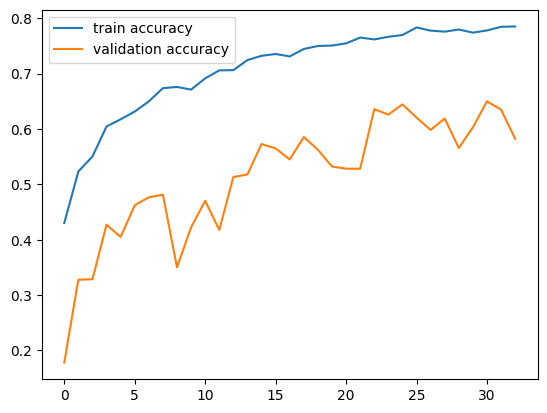

In [14]:

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()


In [16]:

# Saving the model
cnn.save('second_cnn_try_categorical.h5')


40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 278ms/step
[[39 34 20 57 63 10]
 [34 37 34 49 51 19]
 [36 34 12 47 57 18]
 [25 38 18 41 53 12]
 [39 32 21 68 69  9]
 [23 32 15 45 48 18]]


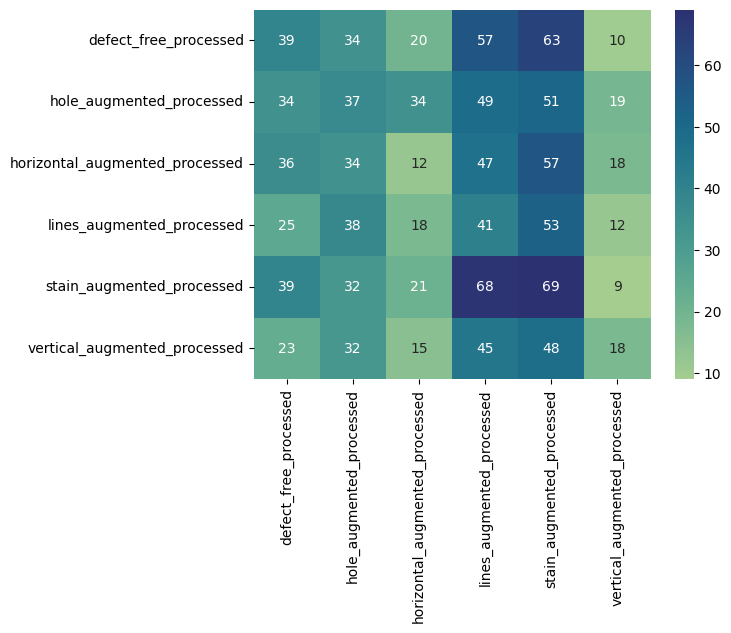


Classification Report:
                                 precision    recall  f1-score   support

         defect_free_processed       0.20      0.17      0.19       223
      hole_augmented_processed       0.18      0.17      0.17       224
horizontal_augmented_processed       0.10      0.06      0.07       204
     lines_augmented_processed       0.13      0.22      0.17       187
     stain_augmented_processed       0.20      0.29      0.24       238
  vertical_augmented_processed       0.21      0.10      0.13       181

                      accuracy                           0.17      1257
                     macro avg       0.17      0.17      0.16      1257
                  weighted avg       0.17      0.17      0.16      1257



In [17]:

# Evaluating the model
predictions = cnn.predict(val_set)
true_labels = val_set.classes
predicted_labels = np.argmax(predictions, axis=1)

# Confusion Matrix and Metrics
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
sns.heatmap(cm, annot=True, xticklabels=train_set.class_indices.keys(), yticklabels=train_set.class_indices.keys(), cmap="crest")
plt.show()

report = classification_report(true_labels, predicted_labels, target_names=train_set.class_indices.keys())
print("\nClassification Report:\n", report)
